In [1]:
import torch
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [2]:
def summarize_and_load(model_path):
    
    checkpt_dir = '/nfs6/BB/Hendrix_Lab/valejose/bioseq2seq/experiments/checkpoints/coding_noncoding/'
    checkpoint = torch.load(checkpt_dir+model_path, map_location='cpu')
    opts = checkpoint['opt']
    print(f'Loaded model {model_path} with parent {opts.checkpoint} and mode {opts.mode}')
    return checkpoint
'''
shortcuts = {'B1' : 'bioseq2seq_1_Apr23_11-26-20/_step_12500.pt', # 95.77
'B2' : 'bioseq2seq_2_Apr23_11-26-17/_step_17000.pt', # 96.24
'B3' : 'bioseq2seq_3_Apr23_11-26-17/_step_7000.pt', # 95.74
'B4' : 'bioseq2seq_4_Apr23_11-26-17/_step_12500.pt', # 95.66
'EL1' : 'EDC_1_Apr25_14-52-01/_step_6000.pt', # 92.89
'EL2' : 'EDC_2_Apr25_14-52-01/_step_5000.pt', # 92.77
'EL3' : 'EDC_3_Apr25_14-52-01/_step_5000.pt', # 92.48
'EL4' : 'EDC_4_Apr25_14-52-01/_step_5000.pt', # 92.89
'ES1' : 'EDC_eq_1_Apr28_18-18-46/_step_1000.pt', # 89.67
'ES2' : 'EDC_eq_2_Apr28_18-18-46/_step_1000.pt', # 89.13
'ES3' : 'EDC_eq_3_Apr28_18-18-46/_step_1000.pt', # 89.25
'ES4' : 'EDC_eq_4_Apr28_18-18-46/_step_1000.pt'} # 90.12
'''

shortcuts = {'B1' : 'bioseq2seq_1_Jun25_07-51-41/_step_8500.pt',
'B2' : 'bioseq2seq_2_Jun25_07-51-41/_step_10000.pt', 
'B3' : 'bioseq2seq_3_Jun25_07-51-41/_step_17000.pt', 
'B4' : 'bioseq2seq_4_Jun25_07-51-41/_step_10500.pt', 
'EL1' : 'EDC_1_Jun27_08-35-05/_step_6000.pt', 
'EL2' : 'EDC_2_Jun27_08-35-05/_step_4500.pt',
'EL3' : 'EDC_3_Jun27_08-35-05/_step_2000.pt', 
'EL4' : 'EDC_4_Jun27_08-35-05/_step_3000.pt', 
'ES1' : 'EDC_eq_1_Jun29_13-20-08/_step_1500.pt', 
'ES2' : 'EDC_eq_2_Jun29_13-20-08/_step_500.pt', 
'ES3' : 'EDC_eq_3_Jun29_13-20-08/_step_1000.pt', 
'ES4' : 'EDC_eq_4_Jun29_13-20-08/_step_1500.pt'} 

In [3]:

def load_filter_layers(checkpoint,mode='abs'):
    
    global_filters = []
    has_next = True
    i_layer = 0
    while has_next:
        layer = f'encoder.fnet.{i_layer}.global_filter'
        if layer in checkpoint['model']:
            weight = checkpoint['model'][layer]
            if mode == 'abs':
                weight = weight.abs()
            elif mode == 'real':
                weight = weight.real
            elif mode == 'imag':
                weight = weight.imag
            else:
                weight = weight.angle()
            #weight /= torch.linalg.norm(weight,dim=0,ord=2)
            global_filters.append(weight[None])
            i_layer +=1
        else:
            has_next = False
            
    return global_filters
    

In [4]:
%matplotlib inline


In [5]:
def approximate_index(period,filter_size):
    frequency = 1.0 / period
    index = int(2*frequency*filter_size)
    return index

In [6]:
import numpy as np
import seaborn as sns
import torch.nn.functional as F
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors


def plot_filters(global_filter_list,filename,mode):
    
    periods = [18,12,9,6,5,4,3,2]
    L = len(global_filter_list)
    fig, axs = plt.subplots(1,6,figsize=(12,5))
    #fig, axs = plt.subplots(1,3,figsize=(9,9))

    
    index_list = list(range(L))
    print(index_list)
    mid = L // 2
    
    index_list = [0,1,mid-1,mid,L-2,L-1]
    #index_list = [0,mid,L-1]
    total = torch.stack(global_filter_list,dim=0)
    index_tensor = torch.tensor(index_list)
    total = torch.index_select(total,0,index_tensor)
    global_min = total.min().item()
    global_max = total.max().item()
    
    if mode == 'abs':
        vmin = 0.0
        vmax = global_max
    elif mode == 'phase':
        vmin = -3.14
        vmax = 3.14
    else:
        global_range = max(global_max,abs(global_min))
        vmin = -global_range
        vmax = global_range
        
    cmap = 'plasma' if mode == 'abs' else 'seismic'
    
    for j,i in enumerate(index_list):
        
        gf = global_filter_list[i].numpy().squeeze()
        im = axs[j].imshow(gf,cmap=cmap,aspect='auto',vmin=vmin,vmax=vmax)
        tick_locs = [approximate_index(p,gf.shape[0]) for p in periods]
        
        axs[j].set_title(f'Layer {i}',fontsize=20)
        if j == 0:
            axs[j].set_ylabel("Period (nt.)",fontsize=20)
            axs[j].set_xlabel("embed. dim.",fontsize=20)
            axs[j].set_yticks(tick_locs)
            axs[j].set_yticklabels(periods,fontsize=16)

        else:
            axs[j].set_yticks([])
            axs[j].set_yticklabels([])

        if j % 2 ==0:
            axs[j].set_xticks([0,gf.shape[1]])
        else:
            axs[j].set_xticks([])
    
    plt.tight_layout(w_pad=0.1)

    if mode == 'phase':
        ticks=[-3.14,-1.57,0,1.57,3.14]
        cb = plt.colorbar(im,ax=axs.flat,ticks=ticks) 
        cb.ax.set_yticklabels(['-π','-π/2','0','π/2','π'])
    else:
        cb = plt.colorbar(im,ax=axs.flat) 

    cb.ax.tick_params(labelsize=20)
    plt.savefig(filename)



Loaded model EDC_1_Jun27_08-35-05/_step_6000.pt with parent None and mode EDC
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


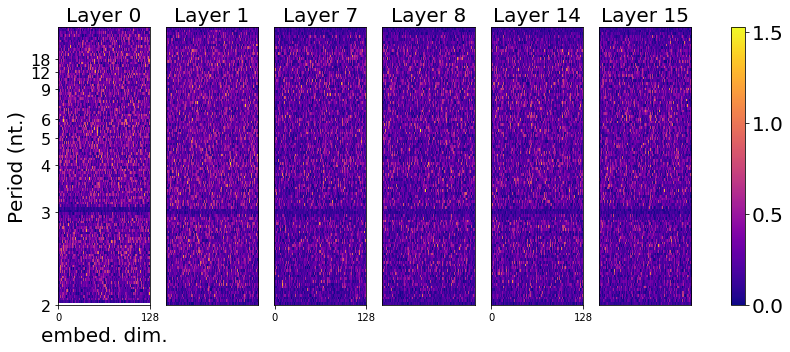

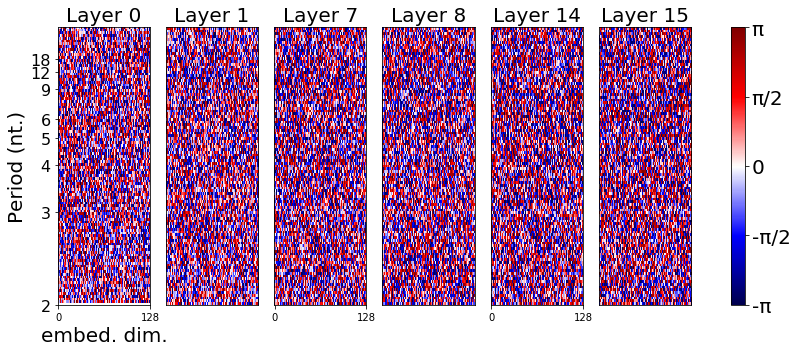

In [21]:
checkpoint = summarize_and_load(shortcuts['EL1'])
mode = 'abs'
EDC_filters_abs = load_filter_layers(checkpoint,mode=mode)
plot_filters(EDC_filters_abs,f'LFNet_filters_EDC_large_1_{mode}.svg',mode=mode)

mode ='phase'
EDC_filters_phase = load_filter_layers(checkpoint,mode=mode)
plot_filters(EDC_filters_phase,f'LFNet_filters_EDC_large_1_{mode}.svg',mode=mode)

Loaded model bioseq2seq_4_Jun25_07-51-41/_step_10500.pt with parent None and mode bioseq2seq
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


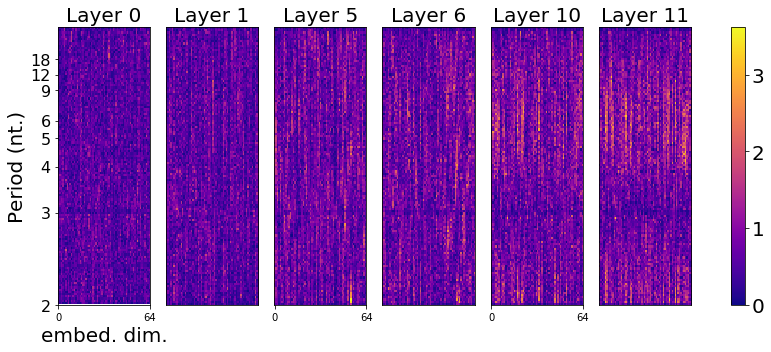

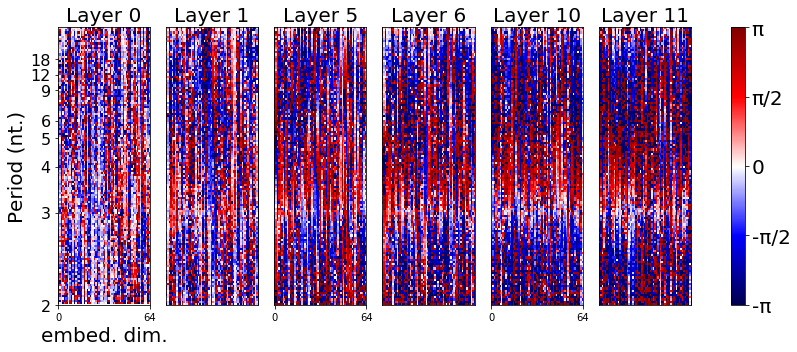

In [50]:
checkpoint = summarize_and_load(shortcuts['B4'])
mode ='abs'
bioseq2seq_filters_abs = load_filter_layers(checkpoint,mode=mode)
plot_filters(bioseq2seq_filters_abs,f'LFNet_filters_bioseq2seq_4_{mode}.svg',mode=mode)

mode = 'phase'
bioseq2seq_filters_phase = load_filter_layers(checkpoint,mode=mode)
plot_filters(bioseq2seq_filters_phase,f'LFNet_filters_bioseq2seq_4_{mode}.svg',mode=mode)

mode = 'real'
bioseq2seq_filters_real = load_filter_layers(checkpoint,mode=mode)

mode = 'imag'
bioseq2seq_filters_imag = load_filter_layers(checkpoint,mode=mode)


In [ ]:
def phase_hist(global_filter_list,filename):
    
    L = len(global_filter_list)
    fig, axs = plt.subplots(1,6,figsize=(10,1.75),sharey=True)

    index_list = list(range(L))
    print(index_list)
    mid = L // 2
    
    index_list = [0,1,mid-1,mid,L-2,L-1]
    for i,ax in zip(index_list,axs.flat):
        phase = global_filter_list[i]
        flat = phase.ravel()
        g = sns.histplot(flat,bins=np.linspace(-3.14,3.14,32),ax=ax)
        ax.set_xticks([-3.14,-1.57,0,1.57,3.14])
        ax.set_xticklabels(['-π','-π/2','0','π/2','π'])
        ax.set_title(f'Layer {i}')
        ax.set_xlabel('Phase')
    
    plt.tight_layout(w_pad=0.1)
    plt.savefig(filename)
    

In [ ]:
phase_hist(bioseq2seq_filters_phase,'LFNet_filters_bioseq2seq_4_phase_hist.svg')

In [ ]:
phase_hist(EDC_filters_phase,'LFNet_filters_EDC_large_1_phase_hist.svg')

In [ ]:
torch.count_nonzero(bioseq2seq_filters_real[11] == 0.0)

In [63]:
torch.count_nonzero(bioseq2seq_filters_imag[11] == 0.0)

tensor(0)